In [36]:
!pip install -q seaborn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


file_url = 'https://raw.githubusercontent.com/kiseli98/ai_lab3/main/apartmentComplexData%20-%20Copy.csv'
column_names = ['complexAge', 'totalRooms', 'totalBedrooms', 'complexInhabitants', 'apartmentsNr', 'medianCompexValue']
raw_dataset = pd.read_csv(file_url, names=column_names)

dataset = raw_dataset.copy()
dataset.tail()

,complexAge,totalRooms,totalBedrooms,complexInhabitants,apartmentsNr,medianCompexValue
20635,25,1665,374,845,330,78100
20636,18,697,150,356,114,77100
20637,17,2254,485,1007,433,92300
20638,18,1860,409,741,349,84700
20639,16,2785,616,1387,530,89400


In [2]:
train_dataset = dataset.sample(frac=0.9, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# train_dataset = dataset.sample(n = 5000)
# test_dataset = dataset.drop(train_dataset.index)
# test_dataset = test_dataset.sample(n = 200)

print(len(train_dataset.index))
print(len(test_dataset.index))

18576
2064


## Inspecting the data

Looking at the joint distribution of a few pairs of columns from the training set in order to determine dependencies between features and **labels**

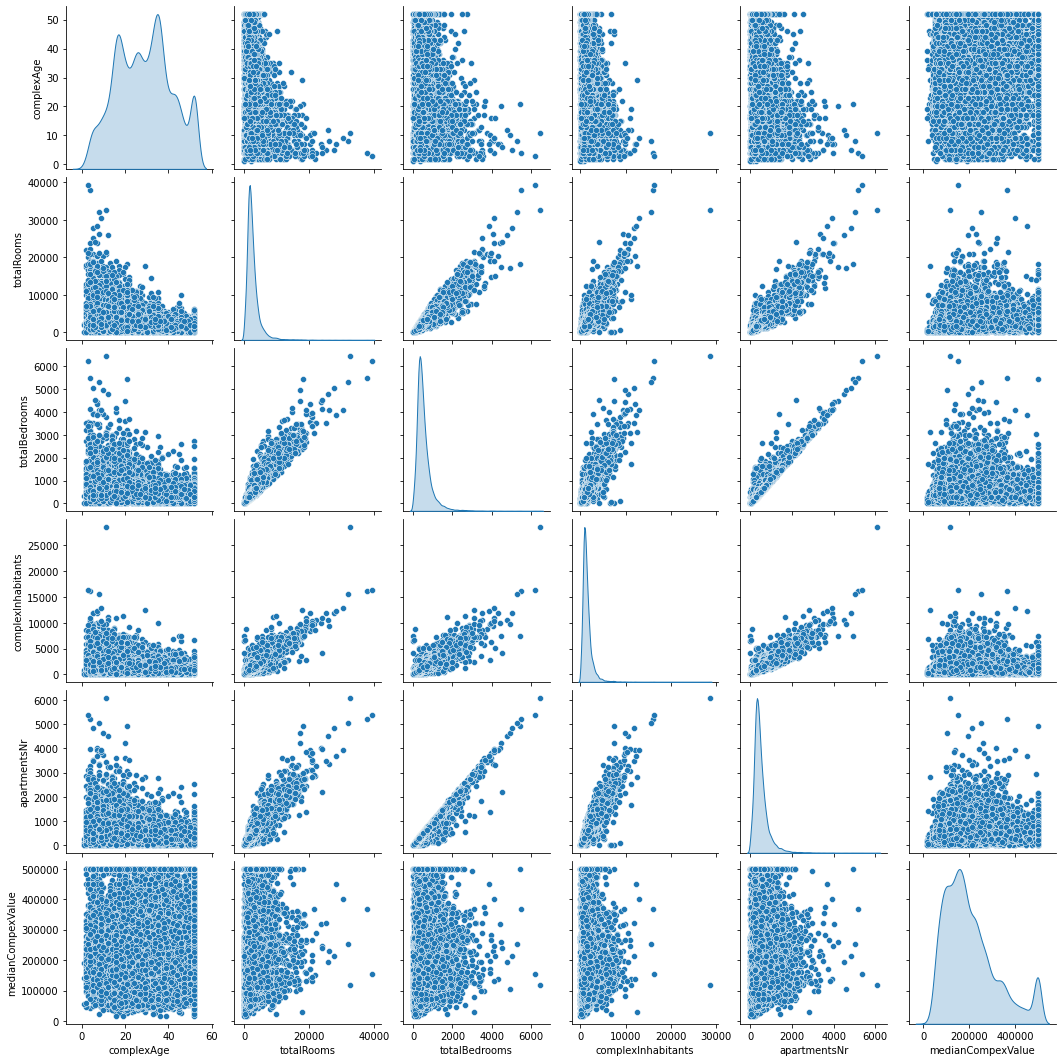

In [3]:
sns.pairplot(train_dataset[column_names], diag_kind='kde')

In [4]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
complexAge,18576.0,28.653478,12.595755,1.0,18.0,29.0,37.00,52.0
totalRooms,18576.0,2626.413544,2151.718240,2.0,1448.0,2121.0,3140.25,39320.0
totalBedrooms,18576.0,536.296135,415.851509,1.0,295.0,434.0,646.00,6445.0
complexInhabitants,18576.0,1422.518196,1101.483506,3.0,788.0,1165.0,1724.00,28566.0
apartmentsNr,18576.0,498.222653,377.821721,1.0,280.0,409.0,604.00,6082.0
medianCompexValue,18576.0,206796.014427,115421.018495,14999.0,119500.0,179700.0,264600.00,500001.0


In [5]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

# Separate the target value (label) from the features. 
# Model will predict label
train_labels = train_features.pop('medianCompexValue')
test_labels = test_features.pop('medianCompexValue')

train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
complexAge,28.653478,12.595755
totalRooms,2626.413544,2151.718240
totalBedrooms,536.296135,415.851509
complexInhabitants,1422.518196,1101.483506
apartmentsNr,498.222653,377.821721
medianCompexValue,206796.014427,115421.018495


The ranges of each feature differ a lot between themselves, so normalization can be applied to the data. It is good practice to normalize features that use different scales and ranges.

In [6]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))


first_sample = np.array(train_features[:10])
# for sample in first_sample:
with np.printoptions(precision=6, suppress=True):
  print('First example:', first_sample)
  print()
  print('Normalized:', normalizer(first_sample).numpy())

First example: [[  22 2101  399 1551  371]
 [  32 2620  398 1296  429]
 [  29 3167  548 1554  534]
 [  37  709  187  390  142]
 [  25 1637  394  649  379]
 [  52  477  119  218  106]
 [  16 1606  240 1117  268]
 [  37 1982  331  794  340]
 [  12 7490 1207 3329 1136]
 [  44  724  133  373  133]]

Normalized: [[-0.528246 -0.24419  -0.330166  0.116647 -0.336736]
 [ 0.265694 -0.002981 -0.33257  -0.114865 -0.18322 ]
 [ 0.027512  0.251242  0.028145  0.119371  0.094696]
 [ 0.662664 -0.891132 -0.839977 -0.937414 -0.942858]
 [-0.290064 -0.459837 -0.342189 -0.70227  -0.315561]
 [ 1.853573 -0.998956 -1.003501 -1.093571 -1.038144]
 [-1.00461  -0.474245 -0.712524 -0.277377 -0.609358]
 [ 0.662664 -0.299496 -0.49369  -0.570626 -0.418787]
 [-1.322186  2.260388  1.612888  1.730878  1.688083]
 [ 1.218421 -0.884161 -0.969834 -0.952848 -0.966679]]


Multi-input linear regression is the application of a linear transformation $(y=mx+b)$ to produce 1 output, where $m$ is matrix and $b$ is vector.

Keras Sequential model represents a sequence of steps:


*   Data normalization
*   Application of linear transformation 



In [7]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 17
Trainable params: 6
Non-trainable params: 11
_________________________________________________________________


Running the untrained model on the first 10 values

In [8]:
linear_model.predict(train_features[:10])

array([[ 0.34243885],
       [-0.04543198],
       [ 0.17781621],
       [-1.1272255 ],
       [-0.26374522],
       [-1.8762733 ],
       [ 0.49908826],
       [-0.65174514],
       [ 2.2393045 ],
       [-1.3592349 ]], dtype=float32)

In [9]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(5, 1) dtype=float32, numpy=
array([[-0.59998393],
       [ 0.32924533],
       [-0.97498345],
       [ 0.5145304 ],
       [ 0.81971216]], dtype=float32)>

### Training model configuration 
Mean absolute error will be optimized using Adam algorithm. Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

In [10]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = linear_model.fit(
    train_features, train_labels, 
    epochs=200,
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [11]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
195,197737.828125,197542.187500,195
196,197691.515625,197495.812500,196
197,197645.156250,197449.546875,197
198,197598.718750,197403.250000,198
199,197552.453125,197356.921875,199


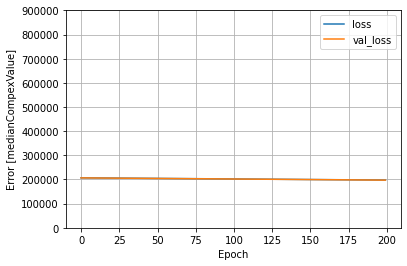

In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 900000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [medianCompexValue]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [17]:
test_results = {}
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [18]:
pd.DataFrame(test_results, index=['Mean absolute error [medianCompexValue]']).T

,Mean absolute error [medianCompexValue]
linear_model,198100.421875


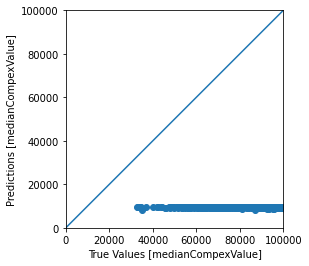

In [19]:
test_predictions = linear_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [medianCompexValue]')
plt.ylabel('Predictions [medianCompexValue]')
lims = [0, 100000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [23]:
# column_names = ['complexAge', 'totalRooms', 'totalBedrooms', 'complexInhabitants', 'apartmentsNr']
user_input = [[21,916,194,451,178]]   # should be 63300 - original value
prediction =  linear_model.predict(user_input).flatten()
print('Predicted value: ',prediction)

Predicted value:  [9566.302]


# DNN Model

In [24]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
_________________________________________________________________


In [25]:
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,80368.679688,77690.250000,95
96,80306.398438,77630.093750,96
97,80248.250000,77609.671875,97
98,80195.789062,77533.054688,98
99,80127.062500,77472.695312,99


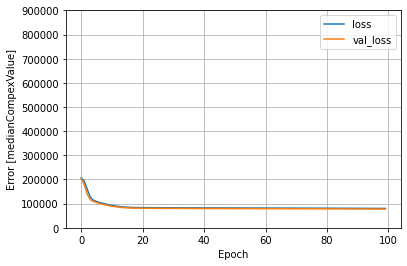

In [27]:
plot_loss(history)

In [28]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [medianCompexValue]']).T

,Mean absolute error [medianCompexValue]
linear_model,198100.421875
dnn_model,79513.148438


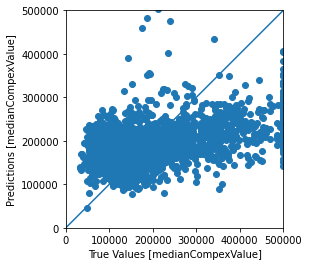

In [29]:
test_predictions_dnn = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions_dnn)
plt.xlabel('True Values [medianCompexValue]')
plt.ylabel('Predictions [medianCompexValue]')
lims = [0, 500000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [30]:
# column_names = ['complexAge', 'totalRooms', 'totalBedrooms', 'complexInhabitants', 'apartmentsNr']
user_input = [[21,916,194,451,178]]   # should be 63300 - original value
prediction =  dnn_model.predict(user_input).flatten()
print('Predicted value: ',prediction)

Predicted value:  [163709.73]


## Linear Regression using scikit learn

In [30]:
column_names = ['complexAge', 'totalRooms', 'totalBedrooms', 'complexInhabitants', 'apartmentsNr', 'medianCompexValue']
feature_cols = ['complexAge', 'totalRooms', 'totalBedrooms', 'complexInhabitants', 'apartmentsNr']
data = pd.read_csv('https://raw.githubusercontent.com/kiseli98/ai_lab3/main/apartmentComplexData%20-%20Copy.csv', names=column_names)


train_dataset = data.sample(frac=0.9, random_state=0)
test_dataset = data.drop(train_dataset.index)

# train_dataset = data.sample(n = 100)
# test_dataset = data.drop(train_dataset.index)
# test_dataset = test_dataset.sample(n = 20)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

# Separate the target value (label) from the features. 
# Model will predict label
train_labels = train_features.pop('medianCompexValue')
test_labels = test_features.pop('medianCompexValue')

lr_model = linear_model.LinearRegression()

# Train the model using the training sets
lr_model.fit(train_features, train_labels)

# Make predictions using the testing set
prediction = lr_model.predict(test_features)

print('Coefficients: \n', lr_model.coef_)
print('Mean squared error: %.2f'
      % mean_squared_error(test_labels, prediction))
print('Coefficient of determination: %.2f'
      % r2_score(test_labels, prediction))


Coefficients: 
 [1587.63756243   46.28727923 -295.25897101  -70.75348865  300.71784742]
Mean squared error: 11782136665.79
Coefficient of determination: 0.11


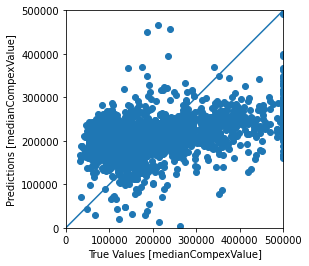

In [31]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, prediction)
plt.xlabel('True Values [medianCompexValue]')
plt.ylabel('Predictions [medianCompexValue]')
lims = [0, 500000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [35]:
#predict for custom variables
user_input = [[21,916,194,451,178]]   # should be 63300 - original value
prediction =  lr_model.predict(user_input).flatten()
print('Predicted value: ',prediction)

Predicted value:  [188982.31585738]
